In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, accuracy_score, precision_score, roc_curve, auc, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.tree import DecisionTreeClassifier

In [2]:
plt.style.use("seaborn-v0_8-darkgrid")

In [3]:
# import datasets
dna_meth = pd.read_csv("data/G7_colon_dna-meth.csv")
gene_expr = pd.read_csv("data/G7_colon_gene-expr.csv")

In [4]:
dna_meth.head()

,Unnamed: 0,Label,cg00002719,cg00020191,cg00021558,cg00024472,cg00058329,cg00060320,cg00063174,cg00063471,...,rs7746156,rs798149,rs845016,rs877309,rs9292570,rs9363764,rs939290,rs951295,rs966367,rs9839873
0,TCGA.3L.AA1B.01,Primary Tumor,0.425515,0.436703,0.470791,0.489124,0.520848,0.564841,0.027920,0.364866,...,0.017584,0.015110,0.578530,0.473453,0.963402,0.047875,0.961194,0.508204,0.036712,0.094153
1,TCGA.4N.A93T.01,Primary Tumor,0.672130,0.106270,0.155840,0.543090,0.844422,0.278043,0.038139,0.053559,...,0.455199,0.966917,0.488998,0.022801,0.966083,0.547980,0.937287,0.762945,0.036739,0.086851
2,TCGA.4T.AA8H.01,Primary Tumor,0.748268,0.164050,0.311851,0.569771,0.807615,0.093203,0.766712,0.750500,...,0.376560,0.967753,0.924707,0.017236,0.413866,0.046266,0.023421,0.971497,0.916638,0.447129
3,TCGA.5M.AAT4.01,Primary Tumor,0.734855,0.305086,0.124479,0.606617,0.643406,0.601940,0.558619,0.517065,...,0.967592,0.967524,0.908705,0.248435,0.020239,0.692241,0.952129,0.973124,0.940750,0.241967
4,TCGA.5M.AAT5.01,Primary Tumor,0.784616,0.098849,0.062913,0.012552,0.121438,0.224108,0.521054,0.032354,...,0.480225,0.386619,0.844465,0.222554,0.178524,0.029880,0.478118,0.970486,0.519334,0.053877


In [5]:
dna_meth["Label"].describe()

count               333
unique                2
top       Primary Tumor
freq                295
Name: Label, dtype: object

In [6]:
gene_expr.head()

,Unnamed: 0,Label,..100130426,..100133144,..100134869,..10357,..10431,..136542,..155060,..26823,...,ZXDA.7789,ZXDB.158586,ZXDC.79364,ZYG11A.440590,ZYG11B.79699,ZYX.7791,ZZEF1.23140,ZZZ3.26009,psiTPTE22.387590,tAKR.389932
0,TCGA.3L.AA1B.01,Primary Tumor,0.5174,18.0851,15.7640,144.4004,774.6615,0.0,441.9729,1.9342,...,71.0832,461.3153,1105.4159,3.3849,543.0368,6259.1876,1358.3172,798.3559,13.0561,0.0000
1,TCGA.4N.A93T.01,Primary Tumor,0.0000,4.4315,4.2767,142.6609,1185.2927,0.0,522.0126,0.4838,...,39.6710,366.7150,1149.4920,0.4838,290.7596,4653.1205,1220.1258,333.8171,1.9352,0.9676
2,TCGA.4T.AA8H.01,Primary Tumor,0.0000,9.8995,11.3032,143.1987,888.3202,0.0,288.0643,2.9245,...,31.4385,349.4791,1083.5313,0.0000,669.7130,4460.6105,3002.0106,530.0676,2.1934,0.0000
3,TCGA.5M.AAT4.01,Primary Tumor,0.0000,7.9174,18.7608,146.1876,1280.5508,0.0,379.5181,2.1515,...,54.6472,542.1687,1374.3546,0.4303,445.3528,4190.1893,1093.3735,574.4406,6.4544,0.4303
4,TCGA.5M.AAT5.01,Primary Tumor,0.0000,12.2565,20.8826,262.5109,1299.8431,0.0,279.4564,0.9892,...,29.1822,428.3349,1240.9841,3.4623,550.5043,3878.2609,1016.4298,413.0019,17.3115,0.0000


In [7]:
gene_expr["Label"].describe()

count               326
unique                2
top       Primary Tumor
freq                285
Name: Label, dtype: object

In [8]:
def score(pred, true):
    """
    Compute accuracy, f1_score
    1. Accuracy: (TP + TN) / (TP + TN + FP + FN)
    2. F1 Score: 2 * (Precision * Recall) / (Precision + Recall)

    :param pred: predicted labels
    :param true: true labels
    :return: dict with recall, precision, f1_score
    """
    # recall = recall_score(true, pred, pos_label="Solid Tissue Normal")
    # precision = precision_score(true, pred, pos_label="Solid Tissue Normal")
    f1 = f1_score(true, pred, pos_label="Solid Tissue Normal")
    accuracy = accuracy_score(true, pred)


    return {"accuracy": accuracy, "f1_score": f1}

In [9]:
def add_noise(data, noise_level=0.05):
    """
    Add Gaussian noise to the data

    :param data: input data
    :param noise_level: standard deviation of the Gaussian noise
    :return: data with added noise
    """
    noisy_data = data.copy()
    for col in noisy_data.columns:
        noise = np.random.normal(0, noise_level * np.std(noisy_data[col]), size=noisy_data.shape[0])
        noisy_data[col] += noise
    return noisy_data

In [10]:
def shuffle_data(data: pd.Series, shuffle_level=0.1) -> pd.Series:
    """
    Shuffle a fraction of the data
    :param data: input data
    :param shuffle_level: fraction of data to shuffle (0 to 1). 0 means no shuffle, 1 means full shuffle
    :return: shuffled data
    """
    n_samples = len(data)
    n_shuffle = int(shuffle_level * n_samples)
    indices = np.random.choice(n_samples, n_shuffle, replace=False)
    shuffled = data.copy().reset_index(drop=True)
    shuffled[indices] = np.random.permutation(shuffled[indices])
    return shuffled

In [11]:
# Extract features
meth_features = dna_meth.columns[2:]
X_meth = dna_meth[meth_features]
# Extract labels
Y_meth = dna_meth["Label"]

# Split into training and test sets with stratification
X_meth_train, X_meth_test, Y_meth_train, Y_meth_test = train_test_split(X_meth, Y_meth, test_size=0.2,
                                                                        random_state=3141, stratify=Y_meth)

{'accuracy': 0.9701492537313433, 'f1_score': 0.875}


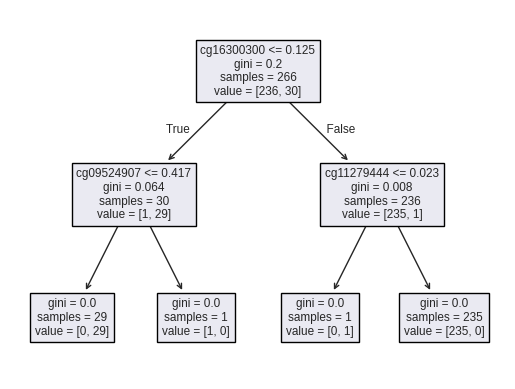

In [12]:
# Fit decision tree
meth_tree = DecisionTreeClassifier()
meth_tree.fit(X_meth_train, Y_meth_train)

# Predict on test set
meth_prediction = meth_tree.predict(X_meth_test)
print(score(meth_prediction, Y_meth_test))

tree.plot_tree(meth_tree, feature_names=meth_features)
plt.show()

In [13]:
# Fit and predict on random forest
meth_forest = RandomForestClassifier(n_estimators=500)
meth_forest.fit(X_meth_train, Y_meth_train)
meth_forest_prediction = meth_forest.predict(X_meth_test)
print(score(meth_forest_prediction, Y_meth_test))

# Get feature importances of top 20 features
feature_importance_df = pd.DataFrame({
    'feature': X_meth_train.columns,
    'importance': meth_forest.feature_importances_
}).sort_values(by='importance', ascending=False)
print(feature_importance_df.head(20))

{'accuracy': 1.0, 'f1_score': 1.0}
         feature  importance
1713  cg09170112    0.017452
150   cg00817367    0.016626
1729  cg09248054    0.016283
485   cg02526522    0.016276
3952  cg21646598    0.014258
3012  cg16302790    0.013340
4030  cg22333214    0.012788
3330  cg17872757    0.012650
1479  cg07974511    0.012259
2950  cg15848890    0.011964
1710  cg09167553    0.011925
756   cg04025964    0.011659
4877  cg27317433    0.011440
3673  cg19897940    0.010987
1932  cg10471437    0.010754
3985  cg21900495    0.010387
616   cg03257172    0.010274
4335  cg24115221    0.009761
875   cg04747226    0.009260
3724  cg20219457    0.009189


In [14]:
# Repeat for gene expression data

gene_features = gene_expr.columns[2:]
X_gene = gene_expr[gene_features]

Y_gene = gene_expr["Label"]

X_gene_train, X_gene_test, Y_gene_train, Y_gene_test = train_test_split(X_gene, Y_gene, test_size=0.2,
                                                                        random_state=1223, stratify=Y_gene)

{'accuracy': 1.0, 'f1_score': 1.0}


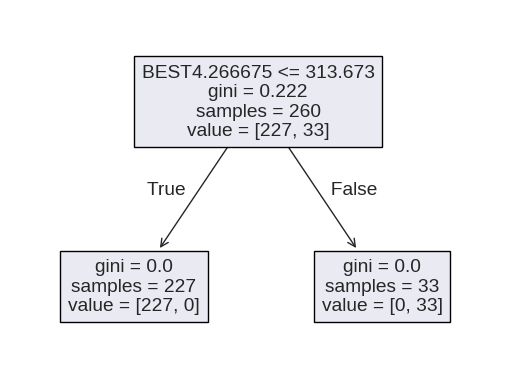

In [15]:
gene_tree = DecisionTreeClassifier()
gene_tree.fit(X_gene_train, Y_gene_train)

gene_prediction = gene_tree.predict(X_gene_test)
print(score(gene_prediction, Y_gene_test))

tree.plot_tree(gene_tree, feature_names=gene_features)
plt.show()
# Gene data seems to perform better initially

In [16]:
gene_forest = RandomForestClassifier(n_estimators=500)
gene_forest.fit(X_gene_train, Y_gene_train)
gene_forest_prediction = gene_forest.predict(X_gene_test)
print(score(gene_forest_prediction, Y_gene_test))

feature_importance_df = pd.DataFrame({
    'feature': X_gene_train.columns,
    'importance': gene_forest.feature_importances_
}).sort_values(by='importance', ascending=False)

print(feature_importance_df.head(20))

{'accuracy': 1.0, 'f1_score': 1.0}
             feature  importance
9268    KRT80.144501    0.014128
12786    OTOP2.92736    0.014099
19440  VSTM2A.222008    0.014042
454     AHCYL2.23382    0.010316
15593     SCGN.10590    0.010000
7555     GUCA2B.2981    0.009886
5752       ETV4.2118    0.009666
5494   EIF4E3.317649    0.008741
5926   FAM135B.51059    0.008000
19548    WDR75.84128    0.007713
3870     CLEC3B.7123    0.007666
10840  METTL7A.25840    0.007540
5374       EDN3.1908    0.007520
19518    WDR43.23160    0.007479
4899     DHDDS.79947    0.007370
3795    CITED2.10370    0.007369
11819    NFE2L3.9603    0.007339
10735      MDFI.4188    0.007247
19615      WNT2.7472    0.007029
17208    SPTBN2.6712    0.007016


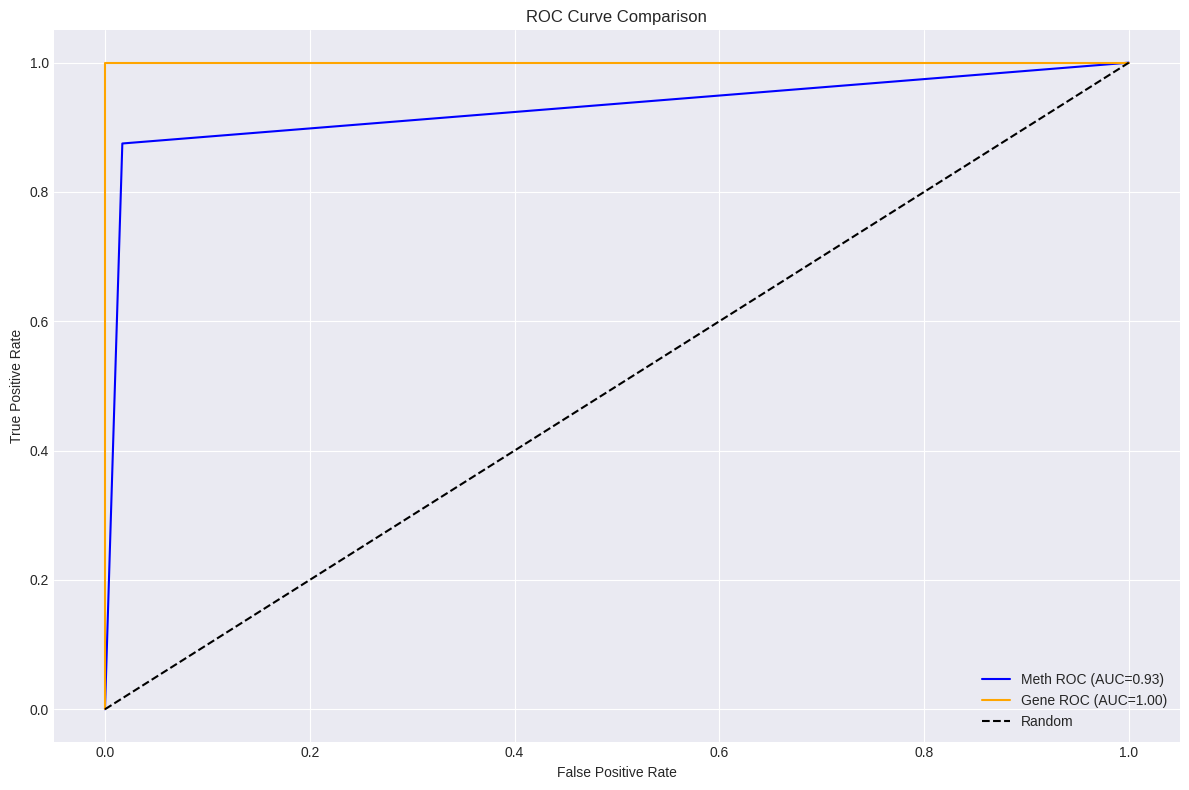

In [17]:
# Binarize labels for ROC/AUC
y_meth_bin = label_binarize(Y_meth_test, classes=["Primary Tumor", "Solid Tissue Normal"])
y_gene_bin = label_binarize(Y_gene_test, classes=["Primary Tumor", "Solid Tissue Normal"])

# Get predicted probabilities
meth_probs = meth_tree.predict_proba(X_meth_test)[:, 1]
gene_probs = gene_tree.predict_proba(X_gene_test)[:, 1]

# Compute ROC curve and AUC
fpr_meth, tpr_meth, _ = roc_curve(y_meth_bin, meth_probs)
fpr_gene, tpr_gene, _ = roc_curve(y_gene_bin, gene_probs)
auc_meth = auc(fpr_meth, tpr_meth)
auc_gene = auc(fpr_gene, tpr_gene)

# Plot ROC curves
plt.figure(figsize=(12, 8))
plt.plot(fpr_meth, tpr_meth, label=f'Meth ROC (AUC={auc_meth:.2f})', color='blue')
plt.plot(fpr_gene, tpr_gene, label=f'Gene ROC (AUC={auc_gene:.2f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Gene expression has a notably higher AUC, indicating better discrimination

In [18]:
meth_results = []
gene_results = []
np.random.seed(40)
# Evaluate performance across different noise levels
for noise in np.arange(0.1, 1.6, 0.1):
    meth_tree.fit(add_noise(X_meth_train, noise), Y_meth_train)
    meth_prediction = meth_tree.predict(X_meth_test)
    meth_scores = score(meth_prediction, Y_meth_test)
    meth_results.append({"noise": noise, **meth_scores})

    gene_tree.fit(add_noise(X_gene_train, noise), Y_gene_train)
    gene_prediction = gene_tree.predict(X_gene_test)
    gene_scores = score(gene_prediction, Y_gene_test)
    gene_results.append({"noise": noise, **gene_scores})

meth_results_df = pd.DataFrame(meth_results)
gene_results_df = pd.DataFrame(gene_results)

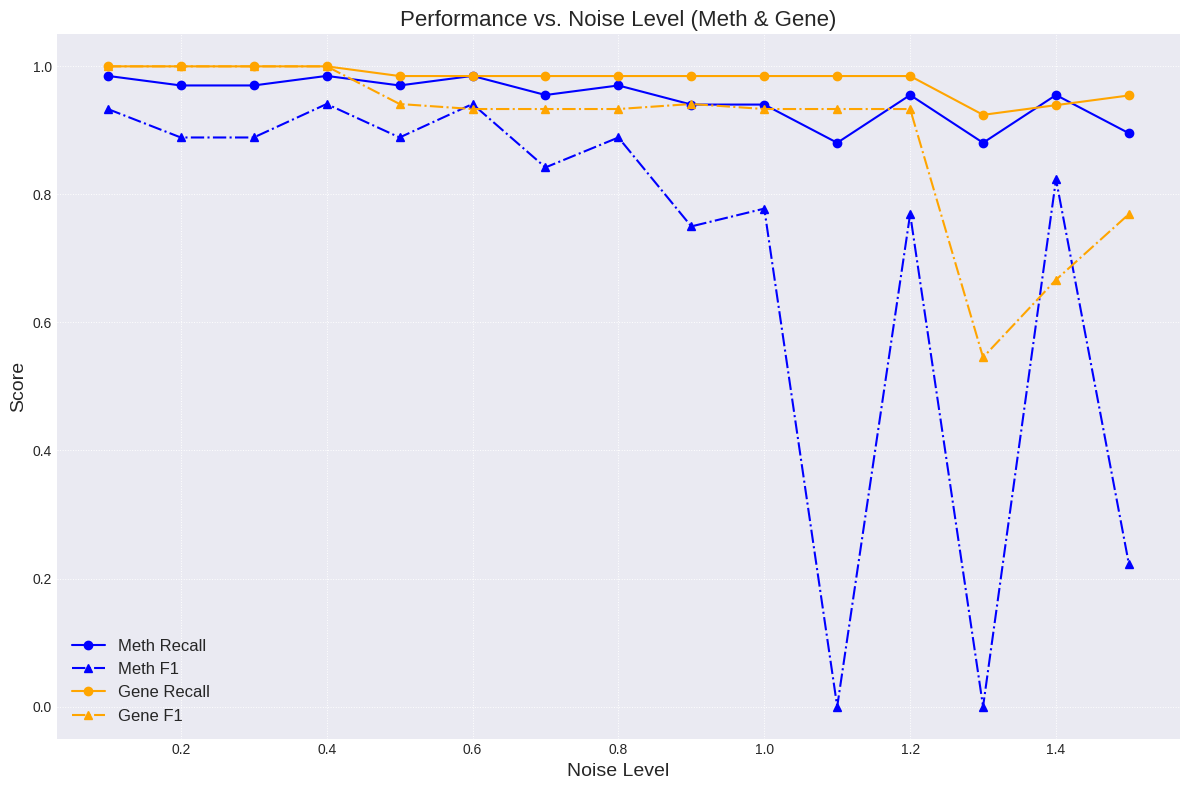

In [20]:
plt.figure(figsize=(12, 8))
plt.plot(meth_results_df["noise"], meth_results_df["accuracy"],
         label="Meth Recall", linestyle='-', color="blue", marker='o')
plt.plot(meth_results_df["noise"], meth_results_df["f1_score"],
         label="Meth F1", linestyle='-.', color="blue", marker='^')
plt.plot(gene_results_df["noise"], gene_results_df["accuracy"],
         label="Gene Recall", linestyle='-', color='orange', marker='o')
plt.plot(gene_results_df["noise"], gene_results_df["f1_score"],
         label="Gene F1", linestyle='-.', color='orange', marker='^')
plt.xlabel("Noise Level", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.legend(fontsize=12)
plt.title("Performance vs. Noise Level (Meth & Gene)", fontsize=16)
plt.grid(True, which='both', linestyle=':', linewidth=0.7)
plt.tight_layout()
plt.show()

# Gene expression data is more robust to noise, suggesting it may have stronger signal

In [21]:
meth_results = []
gene_results = []
np.random.seed(359)
# Evaluate performance across different noise levels
for shuffle in np.arange(0.1, 1.1, 0.1):
    meth_tree.fit(X_meth_train, shuffle_data(Y_meth_train, shuffle))
    meth_prediction = meth_tree.predict(X_meth_test)
    meth_scores = score(meth_prediction, Y_meth_test)
    meth_results.append({"shuffle": shuffle, **meth_scores})

    gene_tree.fit(X_gene_train, shuffle_data(Y_gene_train, shuffle))
    gene_prediction = gene_tree.predict(X_gene_test)
    gene_scores = score(gene_prediction, Y_gene_test)
    gene_results.append({"shuffle": shuffle, **gene_scores})

meth_results_df = pd.DataFrame(meth_results)
gene_results_df = pd.DataFrame(gene_results)

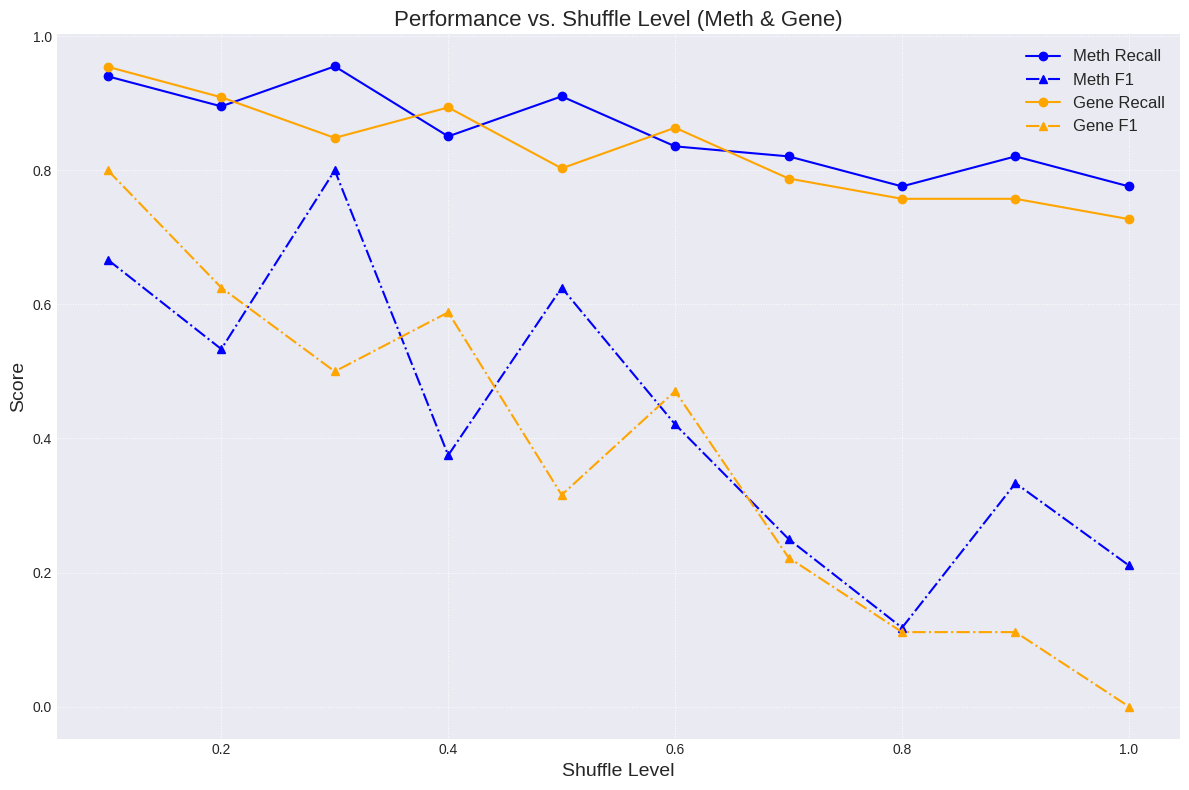

In [23]:
plt.figure(figsize=(12, 8))
plt.plot(meth_results_df["shuffle"], meth_results_df["accuracy"],
         label="Meth Recall", linestyle='-', color="blue", marker='o')
plt.plot(meth_results_df["shuffle"], meth_results_df["f1_score"],
         label="Meth F1", linestyle='-.', color="blue", marker='^')
plt.plot(gene_results_df["shuffle"], gene_results_df["accuracy"],
         label="Gene Recall", linestyle='-', color='orange', marker='o')
plt.plot(gene_results_df["shuffle"], gene_results_df["f1_score"],
         label="Gene F1", linestyle='-.', color='orange', marker='^')
plt.xlabel("Shuffle Level", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.legend(fontsize=12)
plt.title("Performance vs. Shuffle Level (Meth & Gene)", fontsize=16)
plt.grid(True, which='both', linestyle=':', linewidth=0.7)
plt.tight_layout()
plt.show()

# No strong difference between data types when labels are shuffled, both degrade similarly